# A notebook on the variance of the cross validation procedure
In this notebook we try to experimentally confirm the statement that LOOCV has a higher variance than k-fold cross valdation ($k <N$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import KFold
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
N_half = 50
N = 2*N_half #Number of examples
p = 10

### Function for creating training data
We construct the labels randomly, so we know that there is nothing to learn and the true error is 50%.

In [3]:
def makeData():
    '''Create a Nxp random matrix X of data with accompanying N random labels y (1/-1)'''
    X = np.random.normal(size=(N,p)) #yields a Nxp matrix of random numbers 
    y = np.repeat((-1,1),N_half) #yields N_half -1, followed by N_half 1
    y = y[np.random.permutation(N)] #now the labels are also randomly sorted
    return X,y

### Function for performing one pass of k-fold CV
Don't mind the actual classifier used here if you dont know it yet. It doesn't matter.

In [10]:
def one_round_CV(X,y, n_folds):
    '''Performs n_fold CV on (X, y) exactly one time, and returns the average error'''
    kf = KFold(n_splits=n_folds)
    #print(kf)
    acc = 0.0
    rounds = 0.0
    for train, test in kf.split(X):
        model = svm.SVC(kernel='linear', C=0.5).fit(X[train,],y[train])
        res = model.predict(X[test])
        acc += sum(res == y[test])/float(len(test)) #Accuracy
        rounds += 1.0
    return acc / rounds

## 1. Experiment: Taking a few runs of CV

Each cross validation run provides an estimate for the error. We know that the error should be 50%, so let's take a few runs and see what the CV procedure suggests. 

In [11]:
for i in range(3):
    X,y = makeData()
    print("LOOCV: ", one_round_CV(X,y, N), "5-fold CV: ", one_round_CV(X,y, 5)) 

LOOCV:  0.36 5-fold CV:  0.56
LOOCV:  0.68 5-fold CV:  0.6900000000000001
LOOCV:  0.52 5-fold CV:  0.47000000000000003


Each run has a different accuracy estimate (even if already averaged over its k folds). So next we take a lot of runs and record the estimates.
## 2. Experiment: The Averge over many runs

In [12]:
runs = 1000 #average 1000 runs of k-fold CV, k={N, 10, 5, 2}
acc_loo = np.zeros(runs)
acc_10 = np.zeros(runs)
acc_5 = np.zeros(runs)
acc_2 = np.zeros(runs)

#this takes some minutes (ca. 2-3), so show a progress bar
from ipywidgets import FloatProgress
from IPython.display import display
from time import sleep
f = FloatProgress(min=0, max=runs)
display(f)

for i in range(runs):
    f.value = i #update progress bar
    X,y = makeData() #create new data set (true error each time 50%)
    acc_loo[i] = one_round_CV(X,y, N) #LOOCV accuracy
    acc_10[i] = one_round_CV(X,y, 10) #10-fold CV accuracy
    acc_5[i] = one_round_CV(X,y, 5)   #5-fold CV accuracy
    acc_2[i] = one_round_CV(X,y, 2)   #2-fold CV accuracy

FloatProgress(value=0.0, max=1000.0)

In [7]:
np.mean(acc_loo), np.mean(acc_10), np.mean(acc_5), np.mean(acc_2)

(0.48957, 0.48866, 0.49104000000000003, 0.49158)

In [8]:
np.std(acc_loo), np.std(acc_10), np.std(acc_5), np.std(acc_2)

(0.08135425680319378,
 0.06836230247731567,
 0.06574282014030126,
 0.06115475124632592)

## Results: Analyzing the variance
There is a slight (significant?) difference in variance. It seems that LOOCV has a higher variance. Note that due to construction, we do not foresee a bias. While LOOCV has in general a higher variance the bias is in general smaller. This is due to the fact that for LOOCV the model in each split is trained with $N-1$ examples; in 2-fold cross validation each classifier is trained with only $N/2$ examples. $K=10$ is often considered a good tradeoff between the two extremes. The amount of bias depends on the learning rate of the classifiers, see e.g. chapter 7.10 in [ESL, 2009].

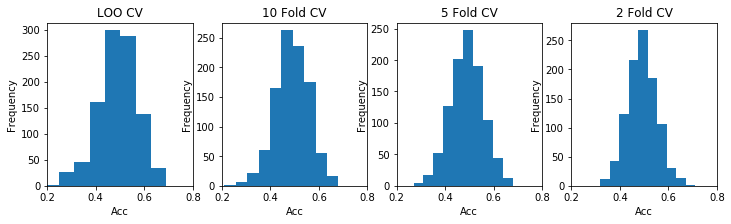

In [9]:
pylab.rcParams['figure.figsize'] = (12.0, 3.0)
plt.subplot(141)
plt.hist(acc_loo)
plt.title("LOO CV")
plt.xlabel("Acc")
plt.ylabel("Frequency")
plt.xlim((0.2,0.8))

plt.subplot(142)
plt.hist(acc_10)
plt.title("10 Fold CV")
plt.xlabel("Acc")
plt.ylabel("Frequency")
plt.xlim((0.2,0.8))

plt.subplot(143)
plt.hist(acc_5)
plt.title("5 Fold CV")
plt.xlabel("Acc")
plt.ylabel("Frequency")
plt.xlim((0.2,0.8))

plt.subplot(144)
plt.hist(acc_2)
plt.title("2 Fold CV")
plt.xlabel("Acc")
plt.ylabel("Frequency")
plt.xlim((0.2,0.8))

plt.show()